# Saliency Visualization

Helpful Links:
https://fairyonice.github.io/Saliency-Map-with-keras-vis.html
https://www.machinecurve.com/index.php/2019/11/25/visualizing-keras-cnn-attention-saliency-maps/#introducing-keras-vis

In [1]:
!pip3 install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps

  Cloning git://github.com/raghakot/keras-vis.git to /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-req-build-m2aneg7v
  Running command git clone -q git://github.com/raghakot/keras-vis.git /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-req-build-m2aneg7v
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30855 sha256=2c1c15d1ac260a3444a85acab6fedc064bc288dc67cc4365df08b68ac4ffcaaa
  Stored in directory: /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-ephem-wheel-cache-1wjjck1u/wheels/d4/f2/90/2fb26be5bf8493b1fadd7c991dc12b9c47cc47c604d214566a
Successfully built keras-vis
  Attempting uninstall: keras-vis
    Found existing installation: keras-vis 0.5.0
    Uninstalling keras-vis-0.5.0:
      Successfully uninstalled keras-vis-0.5.0


In [25]:
!pip3 install -r requirements.txt

import keras
import vis

from keras import activations
from keras.models import load_model
from keras.utils import to_categorical, CustomObjectScope

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from models import AlphaNet

import numpy as np
from numpy import loadtxt

from tools import *
from train import *

from vis.visualization import visualize_saliency
from vis.utils import utils


In [31]:
assert int(tf.__version__[0]) >= 2
from skimage.transform import resize

In [18]:
# load model
custom_metrics = {
    "top3_accuracy": top3_acc,
    "top5_accuracy": top5_acc
}
model = load_model('../BravoNet.h5', custom_objects=custom_metrics) 
model.summary()


Model: "BravoNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet18 (Model)             (None, 3, 3, 512)         11186889  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               102600    
Total params: 11,289,489
Trainable params: 11,281,547
Non-trainable params: 7,942
_________________________________________________________________


In [19]:
X_train, y_train = load_data()
X_val, y_val = load_data("val")
X_test, _ = load_data("test")

y_train = to_categorical(y_train, 200)
y_val = to_categorical(y_val, 200)

Loading train data

Finished loading train data

Loading val data

Finished loading val data

Loading test data

Finished loading test data



In [33]:
boxes = get_box_dict_val()
assert(len(boxes) == len(X_val))


Loading bounding boxes

Done



100000

In [21]:
labels = get_label_dict()
words = get_word_labels()

test_images = os.listdir("data/tiny-imagenet-200/test/images/")
assert len(X_test) == len(test_images)

Loading labels

Done

Loading words

Done



In [22]:
with CustomObjectScope({"top3_accuracy": top3_acc, "top5_accuracy": top5_acc,}):
    layer_index = -1
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)  

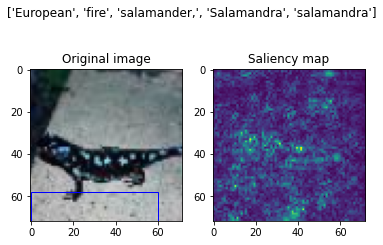

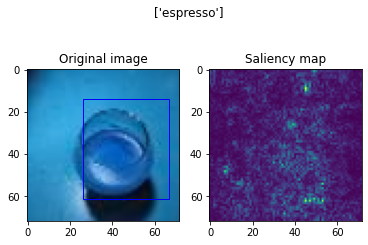

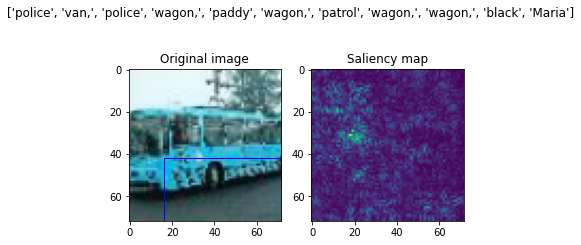

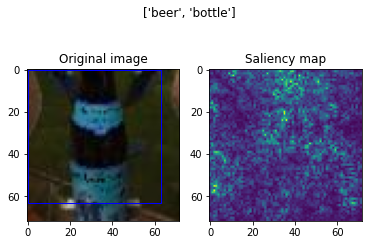

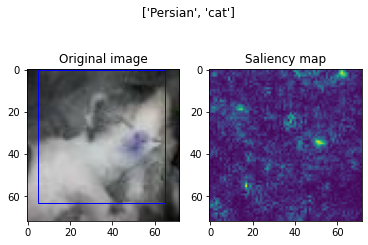

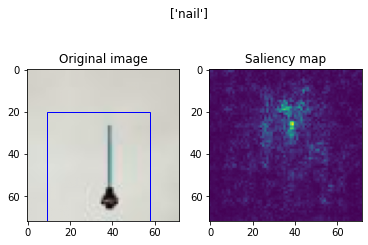

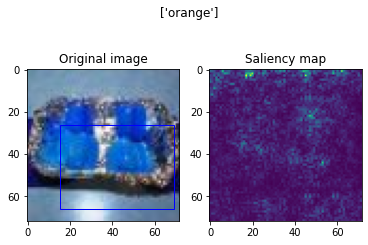

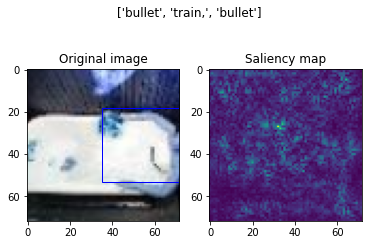

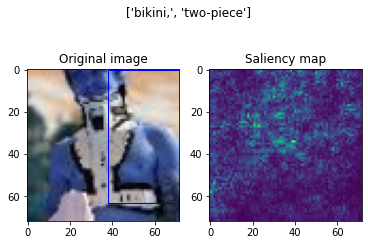

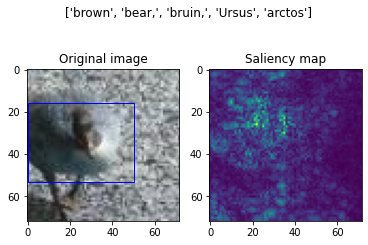

In [42]:
# indices_to_visualize = [ 5, 19, 38, 82, 111, 76, 194 ]
indices_to_visualize = np.random.choice(len(X_val), 10)

with CustomObjectScope({"top3_accuracy": top3_acc, "top5_accuracy": top5_acc,}):

    for index_to_visualize in indices_to_visualize:
        # Get input
        input_image = X_val[index_to_visualize]
        input_class = np.argmax(y_val[index_to_visualize])
        
        # Matplotlib preparations
        fig, axes = plt.subplots(1, 2)
        
        # Generate visualization
        input_image = resize(input_image, (72, 72, 3))
        visualization = visualize_saliency(model, layer_index, filter_indices=input_class, seed_input=input_image)

        y_pred = model.predict(input_image[np.newaxis,...])
        class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

        class_idx = class_idxs_sorted[0]

        axes[0].imshow(input_image) 
        b = boxes['val_'+str(index_to_visualize)+'.JPEG']
        rect = patches.Rectangle((int(b[0]),int(b[1])),int(b[2]),int(b[3]),linewidth=1,edgecolor='b',facecolor='none')
        axes[0].add_patch(rect)
        axes[0].set_title('Original image')
        axes[1].imshow(visualization)

        axes[1].set_title('Saliency map')
        fig.suptitle(words[labels[class_idx]])
        fname = './saliency'+str(index_to_visualize)+'.png'
        plt.savefig(fname, bbox_inches='tight')
        plt.show()


        